## Imports

In [ ]:
!pip install keybert altair

In [ ]:

# RegEx and String Manipulation
import re
import string

# BERT-Embeddings
from keybert import KeyBERT

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting Heatmap of TF-IDF vectors
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('mimetype')

# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image,display

import os
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%time
book_rating = pd.DataFrame() #pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/book2000k-3000k.csv")
for file in tqdm(glob.glob("/content/drive/MyDrive/Datasets/Goodreads/book*.csv")):
    df = pd.read_csv(file)
    if book_rating.empty:
        dfa = df[(df["Language"] == "eng") | (df["Language"] == "en-US")]
        book_rating = dfa
    else:
        dfa = df[(df["Language"] == "eng") | (df["Language"] == "en-US")]
        book_rating = pd.concat([book_rating, dfa], ignore_index=True)


100%|██████████| 23/23 [00:40<00:00,  1.77s/it]

CPU times: user 22.6 s, sys: 1.76 s, total: 24.4 s
Wall time: 41.6 s


In [ ]:
book_rating.shape

(201827, 21)

In [ ]:
book_rating.dropna(subset=["Description"], inplace=True)

In [ ]:
book_rating.Language.value_counts()

eng      105450
en-US     11527
Name: Language, dtype: int64

In [ ]:
book_rating.to_csv("/content/drive/MyDrive/Datasets/Goodreads/english_books_with_description.csv", sep=",", index=False)

In [ ]:
book_rating = book_rating[(book_rating["Language"] == "eng") | (book_rating["Language"] == "en-US")]


In [ ]:
book_rating.shape

(201827, 21)

In [ ]:
book_rating.head()

Id                                               Name RatingDist1  \
0   1  Harry Potter and the Half-Blood Prince (Harry ...      1:9896   
1   2  Harry Potter and the Order of the Phoenix (Har...     1:12455   
2   3  Harry Potter and the Sorcerer's Stone (Harry P...    1:108202   
3   4  Harry Potter and the Chamber of Secrets (Harry...     1:11896   
4   5  Harry Potter and the Prisoner of Azkaban (Harr...     1:10128   

   pagesNumber RatingDist4 RatingDistTotal  PublishMonth  PublishDay  \
0        652.0    4:556485   total:2298124            16           9   
1        870.0    4:604283   total:2358637             1           9   
2        309.0   4:1513191   total:6587388             1          11   
3        352.0    4:706082   total:2560657             1          11   
4        435.0    4:630534   total:2610317             1           5   

         Publisher  CountsOfReview  ...  Language       Authors Rating  \
0  Scholastic Inc.           28062  ...       eng  J.K. Rowling   4.57   
1  Scholastic Inc.           29770  ...       eng  J.K. Rowling   4.50   
2   Scholastic Inc           75911  ...       eng  J.K. Rowling   4.47   
3       Scholastic             244  ...       eng  J.K. Rowling   4.42   
4  Scholastic Inc.           37093  ...       eng  J.K. Rowling   4.57   

   RatingDist2 RatingDist5        ISBN RatingDist3 Description  \
0      2:25317   5:1546466         NaN    3:159960         NaN   
1      2:37005   5:1493113  0439358078    3:211781         NaN   
2     2:130310   5:4268227         NaN    3:567458         NaN   
3      2:49353   5:1504505  0439554896    3:288821         NaN   
4      2:24849   5:1749958  043965548X    3:194848         NaN   

  Count of text reviews  PagesNumber  
0                   NaN          NaN  
1                   NaN          NaN  
2                   NaN          NaN  
3                   NaN          NaN  
4                   NaN          NaN  

[5 rows x 21 columns]

In [ ]:
# Only keep columns we need
eda_data = book_rating[['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description']].copy()
eda_data.head()

Id                                               Name       Authors  \
0   1  Harry Potter and the Half-Blood Prince (Harry ...  J.K. Rowling   
1   2  Harry Potter and the Order of the Phoenix (Har...  J.K. Rowling   
2   3  Harry Potter and the Sorcerer's Stone (Harry P...  J.K. Rowling   
3   4  Harry Potter and the Chamber of Secrets (Harry...  J.K. Rowling   
4   5  Harry Potter and the Prisoner of Azkaban (Harr...  J.K. Rowling   

         ISBN  PublishYear        Publisher Language Description  
0         NaN         2006  Scholastic Inc.      eng         NaN  
1  0439358078         2004  Scholastic Inc.      eng         NaN  
2         NaN         2003   Scholastic Inc      eng         NaN  
3  0439554896         2003       Scholastic      eng         NaN  
4  043965548X         2004  Scholastic Inc.      eng         NaN

In [ ]:
# Minimum number of words that should be present in a description (value starting from 1)
min_description_word_count = 3

In [ ]:
book_rating.columns

Index(['Id', 'Name', 'RatingDist1', 'pagesNumber', 'RatingDist4',
       'RatingDistTotal', 'PublishMonth', 'PublishDay', 'Publisher',
       'CountsOfReview', 'PublishYear', 'Language', 'Authors', 'Rating',
       'RatingDist2', 'RatingDist5', 'ISBN', 'RatingDist3', 'Description',
       'Count of text reviews', 'PagesNumber'],
      dtype='object')

In [ ]:
books_data = book_rating[['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description']].copy(deep=True)
display(books_data.shape)
books_data.head(5)

(201827, 8)

Id                                               Name       Authors  \
0   1  Harry Potter and the Half-Blood Prince (Harry ...  J.K. Rowling   
1   2  Harry Potter and the Order of the Phoenix (Har...  J.K. Rowling   
2   3  Harry Potter and the Sorcerer's Stone (Harry P...  J.K. Rowling   
3   4  Harry Potter and the Chamber of Secrets (Harry...  J.K. Rowling   
4   5  Harry Potter and the Prisoner of Azkaban (Harr...  J.K. Rowling   

         ISBN  PublishYear        Publisher Language Description  
0         NaN         2006  Scholastic Inc.      eng         NaN  
1  0439358078         2004  Scholastic Inc.      eng         NaN  
2         NaN         2003   Scholastic Inc      eng         NaN  
3  0439554896         2003       Scholastic      eng         NaN  
4  043965548X         2004  Scholastic Inc.      eng         NaN

In [ ]:
books_data.isnull().sum()

Id                 0
Name               0
Authors            0
ISBN            1943
PublishYear        0
Publisher       2753
Language           0
Description    84850
dtype: int64

In [ ]:
books_data.dropna(subset=["Description"], inplace=True)

In [ ]:
books_data.isnull().sum()

Id                0
Name              0
Authors           0
ISBN            969
PublishYear       0
Publisher      1487
Language          0
Description       0
dtype: int64

In [ ]:
def add_nan(x):
  x = str(x)
  if x == "": x = "nan"
  return x

In [ ]:
books_data['Description'] = books_data["Description"].apply(add_nan)

In [ ]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
def remove_url(text):
    return re.sub(url_pattern, r'', text)

html_pattern = re.compile('<[^>]*>')
def clean_html_tags(text):
    return re.sub(html_pattern, r'', text)

punctuations = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', punctuations))

books_data.Description = books_data.Description.apply(remove_url)
books_data.Description = books_data.Description.apply(clean_html_tags)
books_data.Description = books_data.Description.apply(remove_punctuations)


In [ ]:
books_data[["Publisher"]] = books_data[["Publisher"]].fillna("unknown")
books_data[["Name", "Authors", "Publisher", "Description"]] = pd.concat([books_data[col].astype(str).str.lower().str.strip()
                                                                             for col in ["Name", "Authors", "Publisher", "Description"]],
                                                                            axis=1)

In [ ]:
# Find description word count
books_data["length"] = [len(d.split()) for d in books_data['Description'].tolist()]

print(set(books_data.Description[books_data.length.isin(range(0,4))]))

{'', 'html', 'geometry textbook', 'british academy 1983', 'classic blecch', 'no', 'weaving', 'favorite stories', 'undefined', 'mass market paperback', 'including 16 maps', 'pulp western', 'romantic suspense novel', 'st a handbook', 'light travel recounting', 'travelhistory', 'out of print', '1887', 'new book', 'disney bambi', 'noveldrama curriculum units', 'poetry collection', '全称《三国志通俗演义》，是中国小说史上长篇章回小说的开山之作。小说以公元184至280年间自黄巾起义至西晋统一的历史故事为素材，用规模宏大的结构和虚实结合的手法，集中描写了魏、蜀、吴三国统治集团之间政治、军事、外交的种种斗争。生动地揭示了统治阶级内部尔虞我诈的勾结与你死我活的斗争的同时，也塑造了一批或智、或忠、或义的生动形象。', 'grades 68', 'the vinegar book', '虫歯が痛いわにさんと治療をする歯医者さん。同じ場面で同じ言葉を言います。それぞれの心理の違いを絵で表現したゆかいな絵本。', 'linford romance library', 'nos 130', 'signed books', 'jennings at school', 'soft cover', 'no synopsis available', '委員長の首筋に、熱烈なキスマークを見つけた日から、米国はいやらしい夢を見る。カタブツの委員長が、眼鏡をとって…米国の腰にまたがる夢だ。男嫌いの米国が、いったいなんでこんな夢を…一方、熊樫先輩の契約hが密かに進行していた。一晩数千ドルの種付け料で…。新装版用描き下ろし6ページを収録', 'third printing', 'peterson western trees', 'modern blackwork', 'poetry', 'popular devotional cl

In [ ]:
# Replace empty strings of description with NaN
books_data.Description = books_data.Description.replace(r'^\s*$', np.nan, regex=True)

books_data[books_data.length.isin(range(1,min_description_word_count+1))][["Id", "Name", "Description", "length"]]\
.sort_values(by=["length"], ascending=True).head(5)

Id                                               Name  \
19282  1113156                                              sybil   
58002  1621630                                     spring is here   
60679  1702293                                  anno's math games   
61817  1734956  the science of the craft: modern realities in ...   
67377  1582820               i knew i was right: an autobiography   

                                             Description  length  
19282                                             novell       1  
58002  生まれたばかりの白い仔牛が立っていて「春が来ます」と始まり、再び春になるまでの成長する仔牛の...       1  
60679  発見の喜び、創造の楽しさに満ちた数学の本と、すでに定評のあった作品を再編集し、新しい体裁でお...       1  
61817                                         nonfiction       1  
67377                                      autobiography       1

In [ ]:
books_data.head()

Id                                               Name  \
18444  1100044  horton hears a who and other sounds of dr. seu...   
18445  1100071  perrine's sound and sense: an introduction to ...   
18446  1100088  the people of glengarry: highlanders in transi...   
18447  1100099  introduction to government and non-for-profit ...   
18448  1100104                                destination unknown   

               Authors        ISBN  PublishYear  \
18444        dr. seuss  0739362658         2008   
18445    thomas r. arp  0838407463         2004   
18446  marianne mclean  0773511563         1993   
18447      martin ives  0130464147         2003   
18448  agatha christie  0312981686         2002   

                             Publisher Language  \
18444        listening library (audio)      eng   
18445                 cengage learning      eng   
18446  mcgill-queen's university press      eng   
18447                    prentice hall      eng   
18448                   minotaur books      eng   

                                             Description  length  
18444  horton hears a who horton the elephant hears a...     210  
18445  an introduction to poetry presented in a compa...      31  
18446  using a wide array of published and unpublishe...      97  
18447  this basiclevel textbook introduces accounting...      38  
18448  american scientist thomas betterton has disapp...      95

In [ ]:
# Convert unknown to NaN
books_data["Publisher"] = books_data.Publisher.replace('unknown',np.nan)
books_data["Description"] = books_data.Description.replace('nan',np.nan)
books_data = books_data.sort_values(by="Publisher", na_position='last')\
.drop_duplicates(subset=["Name", "Authors", "Description"], keep='first')

In [ ]:
series_pattern =  "(?:[;]\s*|\(\s*)([^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*))"
def get_book_series_info(text):
    series_info = re.findall(series_pattern, text)
    if series_info:
        series_info = " ".join([i.replace(" ", "_") for i in series_info])
        return series_info
    else:
        return np.nan

books_data['BookSeriesInfo'] = books_data.Name.apply(get_book_series_info)

In [ ]:
series_remove_pattern = re.compile("(?:[\(]\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)(?:;|\))|\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)\))")
def remove_series_info(text):
    return re.sub(series_remove_pattern, r'', text)

books_data["Title"]= books_data["Name"].str.replace(series_remove_pattern, r'').str.strip()

In [ ]:
#Remove Double Quotes from Publisher Name

books_data["Publisher"] = books_data["Publisher"].str.replace('"','')

In [ ]:
#Transform Book and Author Names into Single Token

books_data["Authors"] = books_data["Authors"].str.strip().str.replace(' ','_')
books_data["Publisher"] = books_data["Publisher"].str.strip().str.replace(' ','_')
books_data.head(5)

Id                                               Name  \
191497   855704  vader's fortress (star wars: junior jedi knigh...   
105823  2983037  come look with me: latin american art (come lo...   
88110   2344635                the night before christmas in texas   
22255   1162741                             zap! i'm a mind reader   
131786  3149837  longarm and the denver executioners (longarm, ...   

                  Authors        ISBN  PublishYear         Publisher Language  \
191497     rebecca_moesta  1572971738         1997           berkley      eng   
105823      kimberly_lane  1890674206         2007     charlesbridge      eng   
88110   catherine___smith  0879054859         2000       gibbs_smith      eng   
22255       dan_greenburg  0448412632         1996  grosset_&_dunlap      eng   
131786        tabor_evans  0515131849         2001              jove      eng   

                                              Description  length  \
191497  anakin solo and his friendsincluding tionne an...      35   
105823  color reproductions of twelve masterpieces are...      78   
88110   a huge windstorm could stop santa from getting...      25   
22255   whod have thought mind reading could be such a...      29   
131786  no one seemed upset to hear that bully cracker...      35   

                            BookSeriesInfo  \
191497  star_wars:_junior_jedi_knights,_#5   
105823                                 NaN   
88110                                  NaN   
22255                                  NaN   
131786                       longarm,_#275   

                                                    Title  
191497                                   vader's fortress  
105823  come look with me: latin american art (come lo...  
88110                 the night before christmas in texas  
22255                              zap! i'm a mind reader  
131786                longarm and the denver executioners

In [ ]:
#Merge All the Textual Summary into a Single Summary Column

books_data["bow"] = books_data[["BookSeriesInfo", 'Authors', 'Publisher', 'Language']].fillna('').agg(' '.join, axis=1)
books_data.bow.iloc[83]

' godfrey_higgins a_&_b_distributors eng'

In [ ]:
# Save cleaned data
books_data.to_csv("/content/drive/MyDrive/Datasets/Goodreads/preprocessed.csv", sep=",", index=False)

In [ ]:
fe_data = pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/preprocessed.csv", usecols=["Id", "Name", "Description", "bow"])
fe_data.head()

In [ ]:
fe_data["Description"] = fe_data["Description"].astype(str)

In [ ]:
fe_data

Id                                               Name  \
0        855704  vader's fortress (star wars: junior jedi knigh...   
1       2983037  come look with me: latin american art (come lo...   
2       2344635                the night before christmas in texas   
3       1162741                             zap! i'm a mind reader   
4       3149837  longarm and the denver executioners (longarm, ...   
...         ...                                                ...   
114767   995666                                            alabama   
114768   996566                                 vagabond, volume 6   
114769   996915                                        coyote blue   
114770   997275                         clanbook: tzimisce revised   
114771   999465                                the history of love   

                                              Description  \
0       anakin solo and his friendsincluding tionne an...   
1       color reproductions of twelve masterpieces are...   
2       a huge windstorm could stop santa from getting...   
3       whod have thought mind reading could be such a...   
4       no one seemed upset to hear that bully cracker...   
...                                                   ...   
114767  politically correct tonis vow anitas fortune m...   
114768  fear failure disgrace even the most renowned s...   
114769  from christopher moore author of fluke comes a...   
114770  a history of evilfrom the antitribu who forged...   
114771  fourteenyearold alma singer is trying to find ...   

                                                      bow  
0       star_wars:_junior_jedi_knights,_#5 rebecca_moe...  
1                         kimberly_lane charlesbridge eng  
2                       catherine___smith gibbs_smith eng  
3                      dan_greenburg grosset_&_dunlap eng  
4                      longarm,_#275 tabor_evans jove eng  
...                                                   ...  
114767                                 kay_cornelius  eng  
114768                                takehiko_inoue  eng  
114769                             christopher_moore  eng  
114770                              lucien_soulban  en-US  
114771                                 nicole_krauss  eng  

[114772 rows x 4 columns]

In [ ]:
kw_model = KeyBERT()

def get_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words="english")
    keywords = " ".join([k[0] for k in keywords])
    return keywords

# fe_data["keywords"] = fe_data.Description.apply(get_keywords)  # Takes a lot of time!!

In [ ]:
fe_data.keywords.head()

0          lightsaber anakin jedi darth tionne
1     painting artists art artist masterpieces
2    santa reindeer windstorm armadillo little
3     reading mind secrets strangeand planning
4         marner custis bully marshal murdered
Name: keywords, dtype: object

In [ ]:
fe_data["keywords"] = fe_data[['bow', 'keywords']].fillna('').agg(' '.join, axis=1)
fe_data.drop(['bow', 'Description'], axis = 1, inplace=True)

In [ ]:
fe_data = fe_data.drop_duplicates(subset=["Name"], keep='first')

In [ ]:
fe_data.to_csv("/content/drive/MyDrive/Datasets/Goodreads/features.csv", sep=",", index=False)


In [ ]:
model_data = pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/features.csv")
model_data.head()

Id                                               Name  \
0   855704  vader's fortress (star wars: junior jedi knigh...   
1  2983037  come look with me: latin american art (come lo...   
2  2344635                the night before christmas in texas   
3  1162741                             zap! i'm a mind reader   
4  3149837  longarm and the denver executioners (longarm, ...   

                                            keywords  
0  star_wars:_junior_jedi_knights,_#5 rebecca_moe...  
1   kimberly_lane charlesbridge eng painting arti...  
2   catherine___smith gibbs_smith eng santa reind...  
3   dan_greenburg grosset_&_dunlap eng reading mi...  
4  longarm,_#275 tabor_evans jove eng marner cust...

Due to limited resources we have to take a random subset from the processed data.

In [ ]:
sampled_data = model_data.sample(n = 40000, random_state = 2).reset_index(drop = True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8',
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(sampled_data["keywords"])

In [ ]:
# Preview first 100 words in the vocabulary
vocabulary = set(tfidf.get_feature_names_out())
print(tfidf.get_feature_names_out()[1:100])

['100' '101' '1066' '12' '13' '1492' '15' '1640' '1660' '1666' '1688'
 '1692' '1707' '1763' '1768' '1773' '1775' '1776' '1777' '1778' '1781'
 '1783' '1787' '1789' '1798' '1800s' '1801' '1803' '1812' '1817' '1818'
 '1826' '1830' '1830s' '1831' '1835' '1836' '1837' '1838' '1840' '1840s'
 '1842' '1843' '1844' '1848' '1850' '1850s' '1852' '1853' '1854' '1857'
 '1859' '1860' '1860s' '1861' '1862' '1863' '1864' '1865' '1870' '1871'
 '1872' '1876' '1877' '1880' '1880s' '1883' '1885' '1886' '1888' '1890'
 '1890s' '1892' '18th' '1900s' '1901' '1903' '1904' '1905' '1908' '1909'
 '1910' '1910s' '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919'
 '1920' '1920s' '1921' '1923' '1924' '1925' '1929' '1930s']


In [ ]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=sampled_data["Name"], columns=tfidf.get_feature_names_out())

# Find top 50 books with maximum tf-idf total score
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
del tfidf_df["total"]


In [ ]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[100:150,25:].copy()
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
display(tfidf_df_preview)

book           term  \
741314                    a deeper blue: passion marks ii      lee_hayes   
739855                    a deeper blue: passion marks ii     infidelity   
747026                    a deeper blue: passion marks ii  strebor_books   
743468                    a deeper blue: passion marks ii      obsession   
747500                    a deeper blue: passion marks ii     temptation   
...                                                   ...            ...   
620977  whiskey and tonic (a whiskey mattimoe mystery,...         estate   
626161  whiskey and tonic (a whiskey mattimoe mystery,...           miss   
620827  whiskey and tonic (a whiskey mattimoe mystery,...          en-us   
615976  whiskey and tonic (a whiskey mattimoe mystery,...           1798   
615977  whiskey and tonic (a whiskey mattimoe mystery,...          1800s   

           tfidf  
741314  0.435366  
739855  0.400788  
747026  0.388522  
743468  0.368927  
747500  0.357225  
...          ...  
620977  0.321757  
626161  0.318423  
620827  0.138032  
615976  0.000000  
615977  0.000000  

[500 rows x 3 columns]

In [ ]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]

    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())
tfidf_vec.iloc[0:5]

book           term     tfidf
741314  a deeper blue: passion marks ii      lee hayes  0.435366
739855  a deeper blue: passion marks ii     infidelity  0.400788
747026  a deeper blue: passion marks ii  strebor books  0.388522
743468  a deeper blue: passion marks ii      obsession  0.368927
747500  a deeper blue: passion marks ii     temptation  0.357225

In [ ]:
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

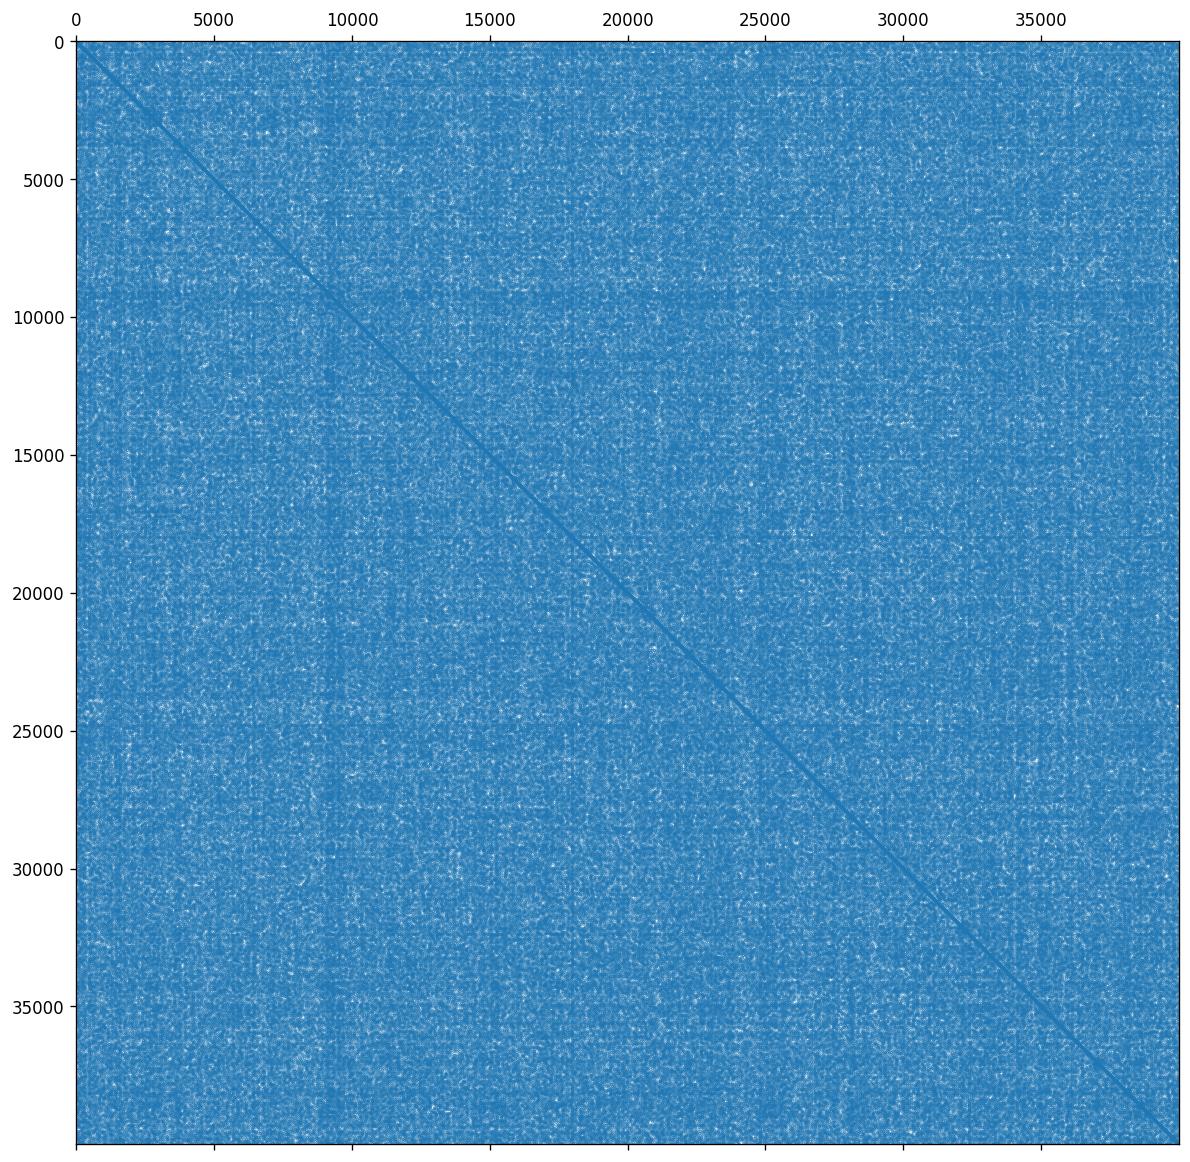

In [ ]:
# Vidualize similarity between books
plt.figure(figsize=(10, 10), dpi=120)
plt.spy(book_cosine_sim, precision = 0.2, markersize = 0.01)
plt.tight_layout()
plt.show()

In [ ]:
books = pd.Series(sampled_data['Name'])

def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    # get index of the imput book
    input_idx = books[books == book_name].index[0]
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)

    books_list = list(books)
    recommended_books = [books[i] for i in top_n_books_idx]

    return recommended_books

In [ ]:
sampled_data

Id                                               Name  \
0      2376106                              looking good in print   
1      1226628                urgent care (the healing touch, #3)   
2      3262818                                             athena   
3      1910121                       sassafras (serendipity book)   
4       672354                    the age of mozart and beethoven   
...        ...                                                ...   
39995  2429136  eggs in the coffee sheep in the corn: my 17 ye...   
39996   608216        the summer garden (the bronze horseman, #3)   
39997  1248558                        perfect girls (replica, #4)   
39998   607911                                it rhymes with lust   
39999  1181285                             a small place in italy   

                                                keywords  
0       roger_c._parker paraglyph_press eng publisher...  
1      the_healing_touch,_#3 hannah_alexander bethany...  
2       blake_hoena capstone_press eng mythology athe...  
3       stephen_cosgrove price_stern_sloan eng elepha...  
4       giorgio_pestelli cambridge_university_press e...  
...                                                  ...  
39995   marjorie_myers_douglas minnesota_historical_s...  
39996  the_bronze_horseman,_#3 paullina_simons harper...  
39997  replica,_#4 marilyn_kaye bantam,australia eng ...  
39998   arnold_drake dark_horse_books eng comic write...  
39999   eric_newby picador eng newby chestnuts newbys...  

[40000 rows x 3 columns]

In [ ]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Author Information) based on the read: naked justice (ben kencaid, #6)"))
display(recommend_books_similar_to("naked justice (ben kencaid, #6)", 5))

Recommendation (Author Information) based on the read: naked justice (ben kencaid, #6)


['cruel justice (ben kincaid, #5)',
 'primary justice (ben kencaid, #1)',
 'silent justice (ben kincaid, #9)',
 'hollowpoint',
 'greek lyric, tragedy, and textual criticism: collected papers']

In [ ]:
# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: the embalmer, volume 4"))
display(recommend_books_similar_to("the embalmer, volume 4", 5))


Recommendation (Numbered Series) based on the read: the embalmer, volume 4


['mitsukazu mihara: haunted house',
 'from eroica with love, vol. 7',
 'doll, volume 6',
 'beautiful people',
 'snow drop, vol. 6']

In [ ]:
print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Neuroscience) based on the read: feminism: feminism and youth culture"))
display(recommend_books_similar_to('feminism and youth culture', 5))


Recommendation (Theme: Neuroscience) based on the read: feminism: feminism and youth culture


['gothic feminism: the professionalization of gender from charlotte smith to the brontës',
 'tourism and gender: embodiment, sensuality and experience',
 'feminist futures?: theatre, performance, theory',
 "a vindication of the rights of woman (everyman's library (cloth))",
 'this bridge called my back: writings by radical women of color']

## Text Query:

In [ ]:
external_query = "A book on geometry and matrices "

In [ ]:
# Preprocess the Query
# query_tokens = external_query.split()
# filtered_query = " ".join([word for word in query_tokens if word in tfidf.vocabulary_])
filtered_query = get_keywords(external_query)

# Transform the Query using TF-IDF Vectorizer
query_tfidf_vector_subset = tfidf.transform([filtered_query])

# Compute Cosine Similarities between the query and all books
query_similarities_subset = cosine_similarity(query_tfidf_vector_subset, tfidf_encoding)

# Recommend based on the highest similarity scores
top_5_indices_subset = query_similarities_subset[0].argsort()[-5:][::-1]
recommended_books_query_subset = sampled_data['Name'].iloc[top_5_indices_subset]

recommended_books_query_subset.tolist()

['linear algebra through geometry',
 'introduction to vector analysis',
 'intersection theory',
 "geometry revealed: a jacob's ladder to higher geometry",
 'mathematical thought from ancient to modern times, volume 3']

## Now Let us integrate NCF:

In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from statistics import mean
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import shuffle
from zipfile import ZipFile
##Deep Learning specific stuff
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate,Add
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.layers import dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2

In [ ]:
%%time

book_rating = pd.DataFrame()
for file in glob.glob("/content/drive/MyDrive/Datasets/Goodreads/book*.csv"):
    df = pd.read_csv(file)
    if book_rating.empty:
        book_rating = df
    else:
        book_rating = pd.concat([book_rating, df], ignore_index=True)


user_rating = pd.DataFrame()
for file in glob.glob("/content/drive/MyDrive/Datasets/Goodreads/user_rating*.csv"):
    df = pd.read_csv(file)
    if user_rating.empty:
        user_rating = df
    else:
        user_rating = pd.concat([user_rating, df], ignore_index=True)

CPU times: user 19.5 s, sys: 2.09 s, total: 21.6 s
Wall time: 22.5 s


In [ ]:
user_rating.head()

ID                                               Name           Rating
0   1  Agile Web Development with Rails: A Pragmatic ...   it was amazing
1   1  The Restaurant at the End of the Universe (Hit...   it was amazing
2   1                                         Siddhartha   it was amazing
3   1  The Clock of the Long Now: Time and Responsibi...  really liked it
4   1            Ready Player One (Ready Player One, #1)  really liked it

In [ ]:
book_rating.tail()

Id                                               Name  \
1850305  999991  Gendered Talk at Work: Constructing Gender Ide...   
1850306  999992  Good Will Toward Men: Women Talk Candidly abou...   
1850307  999993  Would You Rather . . . ?: The Outrageous Book ...   
1850308  999997  Addictions Treatment for Older Adults: Evaluat...   
1850309  999998                                     Within/Without   

        RatingDist1  pagesNumber RatingDist4 RatingDistTotal  PublishMonth  \
1850305         1:0        251.0         4:3        total:25            21   
1850306         1:0        231.0         4:0         total:0             1   
1850307         1:2        400.0        4:35       total:121             1   
1850308         1:0        258.0         4:0         total:0             2   
1850309         1:0         36.0         4:0         total:2             1   

         PublishDay                   Publisher  CountsOfReview  ...  \
1850305           7             Wiley-Blackwell               0  ...   
1850306           2          St. Martin's Press               0  ...   
1850307          10  Workman Publishing Company              14  ...   
1850308           2                   Routledge               0  ...   
1850309           3      Pilgrims Process, Inc.               0  ...   

         Language            Authors Rating  RatingDist2 RatingDist5  \
1850305       NaN      Janet  Holmes   4.28          2:1        5:15   
1850306       NaN        Jack Kammer   0.00          2:0         5:0   
1850307       NaN         Randy Horn   3.81         2:11        5:39   
1850308       NaN     Kathryn Graham   0.00          2:0         5:0   
1850309       NaN  Kathryn T.S. Bass   5.00          2:0         5:2   

               ISBN RatingDist3  \
1850305  1405117591         3:6   
1850306  0312104715         3:0   
1850307  0761124209        3:34   
1850308  1560248572         3:0   
1850309  097495974X         3:0   

                                               Description  \
1850305  <i>Gendered Talk at Work</i> examines how wome...   
1850306  In interviews with gender issues journalist Ja...   
1850307  <i>Would You Rather...?</i> takes the idea of ...   
1850308  Here is a detailed description of an innovativ...   
1850309                                                NaN   

        Count of text reviews  PagesNumber  
1850305                   0.0          NaN  
1850306                   0.0          NaN  
1850307                  14.0          NaN  
1850308                   0.0          NaN  
1850309                   0.0          NaN  

[5 rows x 21 columns]

In [ ]:
book_rating.keys()

Index(['Id', 'Name', 'RatingDist1', 'pagesNumber', 'RatingDist4',
       'RatingDistTotal', 'PublishMonth', 'PublishDay', 'Publisher',
       'CountsOfReview', 'PublishYear', 'Language', 'Authors', 'Rating',
       'RatingDist2', 'RatingDist5', 'ISBN', 'RatingDist3', 'Description',
       'Count of text reviews', 'PagesNumber'],
      dtype='object')

In [ ]:
def complete_preprocessing(book_rating, user_rating):
    """
    Updated preprocessing for the book_rating and user_rating DataFrames.

    Args:
    - book_rating (pd.DataFrame): Raw book rating data.
    - user_rating (pd.DataFrame): Raw user rating data.

    Returns:
    - user_rating_processed (pd.DataFrame): Preprocessed user rating data ready for the model.
    - book_rating_processed (pd.DataFrame): Preprocessed book rating data.
    """

    # Preprocessing for book_rating DataFrame
    book_rating['Num_1star_rating'] = book_rating['RatingDist1'].str.split(':').str[-1].astype(int)
    book_rating['Num_2star_rating'] = book_rating['RatingDist2'].str.split(':').str[-1].astype(int)
    book_rating['Num_3star_rating'] = book_rating['RatingDist3'].str.split(':').str[-1].astype(int)
    book_rating['Num_4star_rating'] = book_rating['RatingDist4'].str.split(':').str[-1].astype(int)
    book_rating['Num_5star_rating'] = book_rating['RatingDist5'].str.split(':').str[-1].astype(int)

    book_rating['Total_rating_count'] = book_rating[['Num_1star_rating', 'Num_2star_rating', 'Num_3star_rating', 'Num_4star_rating', 'Num_5star_rating']].sum(axis=1)

    # Use "Id" as the unique identifier for books
    book_id_0 = book_rating[['Name', 'Id']]
    book_id_1 = user_rating[['Name']]

    book_id = pd.concat([book_id_0,book_id_1],axis=0,ignore_index=True)
    book_id.rename(columns={ book_id.columns[0]: "Name" }, inplace = True)
    book_id.drop_duplicates(inplace=True)
    book_id['Id']=book_id.index.values
    # book_id_1['Id'] = range(1, len(book_id_1) + 1)
    # book_id = pd.concat([book_id_0, book_id_1], axis=0, ignore_index=True).drop_duplicates()

    # Preprocessing for user_rating DataFrame
    user_rating = user_rating[user_rating['ID'].groupby(user_rating['ID']).transform('size') >= 15]
    user_rating = pd.merge(user_rating, book_id, on='Name', how='left')

    le = preprocessing.LabelEncoder()
    user_rating['Rating_numeric'] = le.fit_transform(user_rating.Rating.values)

    book_rating_numeric = book_rating[['Id', 'pagesNumber', 'PublishMonth', 'PublishDay', 'CountsOfReview',
                                       'Num_1star_rating', 'Num_2star_rating', 'Num_3star_rating',
                                       'Num_4star_rating', 'Num_5star_rating']]
    user_rating = pd.merge(user_rating, book_rating_numeric, left_on='Id', right_on='Id', how='left').fillna(0)

    users = user_rating.ID.unique()
    books = user_rating.Id.unique()
    userid2idx = {o: i for i, o in enumerate(users)}
    bookid2idx = {o: i for i, o in enumerate(books)}

    user_rating['ID'] = user_rating['ID'].apply(lambda x: userid2idx[x])
    user_rating['Id'] = user_rating['Id'].apply(lambda x: bookid2idx[x])

    return user_rating, book_rating

# Test the function using the provided datasets (assuming they are loaded)
# user_rating_processed, book_rating_processed = complete_preprocessing(book_rating, user_rating)
# user_rating_processed.head()

user_rating, book_rating = complete_preprocessing(book_rating, user_rating)

In [ ]:
user_rating.head()

ID                                               Name          Rating  Id  \
0   0  Agile Web Development with Rails: A Pragmatic ...  it was amazing   0   
1   0  Agile Web Development with Rails: A Pragmatic ...  it was amazing   1   
2   0  The Restaurant at the End of the Universe (Hit...  it was amazing   2   
3   0  The Restaurant at the End of the Universe (Hit...  it was amazing   3   
4   0  The Restaurant at the End of the Universe (Hit...  it was amazing   4   

   Rating_numeric  pagesNumber  PublishMonth  PublishDay  CountsOfReview  \
0               1        324.0          28.0         5.0          3335.0   
1               1          0.0           0.0         0.0             0.0   
2               1        114.0           1.0         6.0             2.0   
3               1          0.0           0.0         0.0             0.0   
4               1          0.0          10.0        20.0             0.0   

   Num_1star_rating  Num_2star_rating  Num_3star_rating  Num_4star_rating  \
0            1487.0            4717.0           20918.0           35153.0   
1               0.0               0.0               0.0               0.0   
2            2998.0            9321.0           47299.0          106183.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   Num_5star_rating  
0           27216.0  
1               0.0  
2          125746.0  
3               0.0  
4               0.0

In [ ]:
book_rating.tail()

Id                                               Name  \
1850305  999991  Gendered Talk at Work: Constructing Gender Ide...   
1850306  999992  Good Will Toward Men: Women Talk Candidly abou...   
1850307  999993  Would You Rather . . . ?: The Outrageous Book ...   
1850308  999997  Addictions Treatment for Older Adults: Evaluat...   
1850309  999998                                     Within/Without   

        RatingDist1  pagesNumber RatingDist4 RatingDistTotal  PublishMonth  \
1850305         1:0        251.0         4:3        total:25            21   
1850306         1:0        231.0         4:0         total:0             1   
1850307         1:2        400.0        4:35       total:121             1   
1850308         1:0        258.0         4:0         total:0             2   
1850309         1:0         36.0         4:0         total:2             1   

         PublishDay                   Publisher  CountsOfReview  ...  \
1850305           7             Wiley-Blackwell               0  ...   
1850306           2          St. Martin's Press               0  ...   
1850307          10  Workman Publishing Company              14  ...   
1850308           2                   Routledge               0  ...   
1850309           3      Pilgrims Process, Inc.               0  ...   

         RatingDist3                                        Description  \
1850305          3:6  <i>Gendered Talk at Work</i> examines how wome...   
1850306          3:0  In interviews with gender issues journalist Ja...   
1850307         3:34  <i>Would You Rather...?</i> takes the idea of ...   
1850308          3:0  Here is a detailed description of an innovativ...   
1850309          3:0                                                NaN   

        Count of text reviews  PagesNumber Num_1star_rating Num_2star_rating  \
1850305                   0.0          NaN                0                1   
1850306                   0.0          NaN                0                0   
1850307                  14.0          NaN                2               11   
1850308                   0.0          NaN                0                0   
1850309                   0.0          NaN                0                0   

        Num_3star_rating Num_4star_rating Num_5star_rating  Total_rating_count  
1850305                6                3               15                  25  
1850306                0                0                0                   0  
1850307               34               35               39                 121  
1850308                0                0                0                   0  
1850309                0                0                2                   2  

[5 rows x 27 columns]

In [ ]:
book_rating.columns

Index(['Id', 'Name', 'RatingDist1', 'pagesNumber', 'RatingDist4',
       'RatingDistTotal', 'PublishMonth', 'PublishDay', 'Publisher',
       'CountsOfReview', 'PublishYear', 'Language', 'Authors', 'Rating',
       'RatingDist2', 'RatingDist5', 'ISBN', 'RatingDist3', 'Description',
       'Count of text reviews', 'PagesNumber', 'Num_1star_rating',
       'Num_2star_rating', 'Num_3star_rating', 'Num_4star_rating',
       'Num_5star_rating', 'Total_rating_count'],
      dtype='object')

In [ ]:
exogeneous_features = user_rating[['pagesNumber','PublishMonth','PublishDay',\
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',\
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']]

In [ ]:
ncf_model = tf.keras.models.load_model("/content/drive/MyDrive/Datasets/Goodreads/NCF_model.keras")

Train, Test shape:  (1096800, 9) (274201, 9)
Epoch 1/20
8569/8569 [==============================] - 106s 12ms/step - loss: 2.2988 - mae: 1.2659 - val_loss: 1.7296 - val_mae: 1.1311
Epoch 2/20
8569/8569 [==============================] - 98s 11ms/step - loss: 1.7100 - mae: 1.1433 - val_loss: 1.6941 - val_mae: 1.1463
Epoch 3/20
8569/8569 [==============================] - 98s 11ms/step - loss: 1.6518 - mae: 1.1226 - val_loss: 1.6653 - val_mae: 1.1263
Epoch 4/20
8569/8569 [==============================] - 99s 12ms/step - loss: 1.5965 - mae: 1.0948 - val_loss: 1.5801 - val_mae: 1.0970
Epoch 5/20
8569/8569 [==============================] - 98s 11ms/step - loss: 1.5518 - mae: 1.0736 - val_loss: 1.5641 - val_mae: 1.0797
Epoch 6/20
8569/8569 [==============================] - 98s 11ms/step - loss: 1.5284 - mae: 1.0623 - val_loss: 1.6057 - val_mae: 1.1350
Epoch 7/20
8569/8569 [==============================] - 99s 12ms/step - loss: 1.5037 - mae: 1.0513 - val_loss: 1.5908 - val_mae: 1.1158
Ep

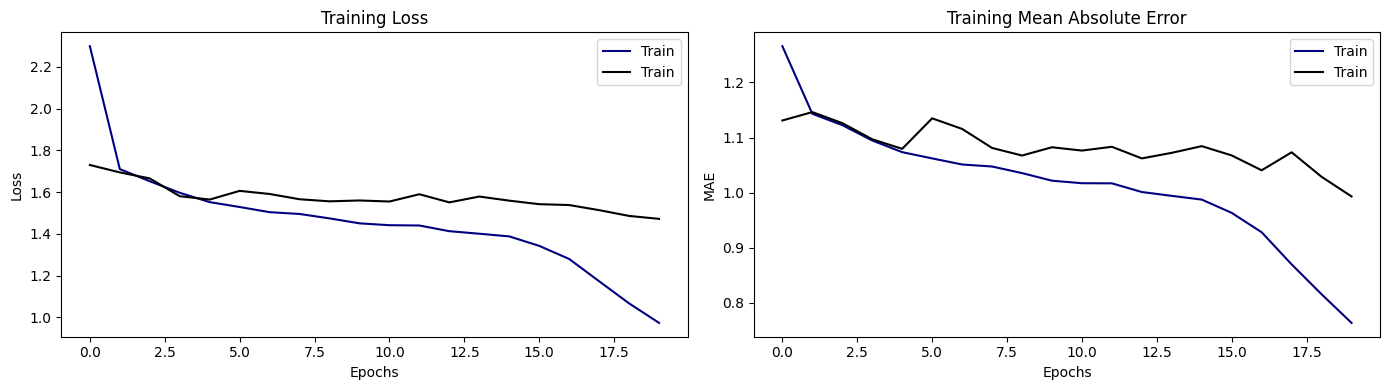

In [ ]:
def build_model(dropout,latent_factors):
    reg_lambda = 0.001
    n_books=len(user_rating['Id'].unique())
    n_users=len(user_rating['ID'].unique())
    n_latent_factors=latent_factors  # hyperparamter to deal with.
    user_input=Input(shape=(1,),name='user_input',dtype='int64')
    user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
    user_vec =Flatten(name='FlattenUsers')(user_embedding)
    user_vec=Dropout(dropout)(user_vec)
    book_input=Input(shape=(1,),name='book_input',dtype='int64')
    book_embedding=Embedding(n_books,n_latent_factors,name='book_embedding')(book_input)
    book_vec=Flatten(name='FlattenBooks')(book_embedding)
    book_vec=Dropout(dropout)(book_vec)
    sim=dot([user_vec,book_vec],name='Similarity-Dot-Product',axes=1)
    ###Exogenous Features input
    exog_input = Input(shape=(9,),name='exogenous_input',dtype='float64')
    exog_embedding = Embedding(9,20,name='exog_embedding')(exog_input)
    exog_embedding = Dense(65,activation='relu',name='exog_Dense')(exog_input)
    exog_vec =Flatten(name='FlattenExog')(exog_embedding)
    ##############
#     nn_inp = Add(dtype='float64',name='Combine_inputs')([sim,exog_vec]) # ORIG, added, ndidn't concat
    nn_inp = tf.keras.layers.Concatenate(name='Combine_inputs')([sim,exog_vec,book_vec,user_vec])
    nn_inp=Dense(128,activation='relu', kernel_regularizer=l2(reg_lambda), name='Main_body_Dense1')(nn_inp)
    nn_inp=BatchNormalization()(nn_inp) # add batch norm here as well
    nn_inp=Dropout(dropout)(nn_inp)
    nn_inp=Dense(64,activation='relu', kernel_regularizer=l2(reg_lambda), name='Main_body_Dense2')(nn_inp)
    nn_inp=BatchNormalization()(nn_inp)
    nn_output=Dense(1, kernel_regularizer=l2(reg_lambda), activation='relu')(nn_inp)
    nn_model =Model([user_input, book_input,exog_input],nn_output)
    return nn_model


def train_ncf_model(user_rating, book_rating, dropout=0.2, latent_factors=128, epochs=5, batch_size=32, learning_rate=0.0001):
    """
    Train the Neural Collaborative Filtering (NCF) model using user_rating and book_rating data.

    Parameters:
    - user_rating: DataFrame containing user-book interactions.
    - book_rating: DataFrame containing book details.
    - dropout: Dropout rate for the dropout layers in the model.
    - latent_factors: Number of latent factors for the embedding layers.
    - epochs: Number of epochs for training.
    - batch_size: Batch size for training.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - Trained NCF model.
    """

    # Extract required columns from user_rating and book_rating
    user_ids = user_rating['ID'].values
    book_ids = user_rating['Id'].values
    ratings = user_rating['Rating_numeric'].values

    # Extract exogeneous features
    exog_features = book_rating[['pagesNumber', 'PublishMonth', 'PublishDay', 'CountsOfReview',
                                 'Num_1star_rating', 'Num_2star_rating', 'Num_3star_rating',
                                 'Num_4star_rating', 'Num_5star_rating']]
    # Ensure that the book IDs in the user_rating dataframe align with the book_rating dataframe
    exog_features = exog_features.reindex(book_ids).values

    # Split Data
    train_user, test_user, \
    train_book, test_book, \
    train_exog, test_exog, \
    train_rating, test_rating = train_test_split(user_ids, book_ids, exog_features, ratings, test_size=0.2, random_state=42)
    print("Train, Test shape: ", train_exog.shape, test_exog.shape)
    # Build the NCF model
    model = build_model(dropout, latent_factors)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # # Train the model
    history = model.fit([train_user, train_book, train_exog], train_rating, epochs=epochs,
              validation_data = ([test_user, test_book, test_exog], test_rating), batch_size=batch_size, verbose=1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    # Plot training loss
    axes[0].plot(history.history['loss'], label='Train', color='navy')
    axes[0].plot(history.history['val_loss'], label='Train', color='black')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')

    # Plot training metric (in this case, MAE)
    axes[1].plot(history.history['mae'], label='Train', color='navy')
    axes[1].plot(history.history['val_mae'], label='Train', color='black')
    axes[1].set_title('Training Mean Absolute Error')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('MAE')
    axes[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return model, (test_user, test_book, test_exog, test_rating)

ncf_model, Test_data = trained_ncf_model = train_ncf_model(user_rating, book_rating, epochs=20, batch_size=128)
train_user, train_book, train_exog, test_rating = Test_data



In [ ]:
ncf_model = build_model(0.3, 128)
ncf_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 book_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       311808      ['user_input[0][0]']             
                                                                                                  
 book_embedding (Embedding)     (None, 1, 128)       54738944    ['book_input[0][0]']             
                                                                                            

In [ ]:
def predict_ncf_with_exogenous(user_ids, book_ids, exogeneous_features, model):
    """
    Generate predictions using the NCF model with exogenous features.

    Args:
    - user_ids (scalar or array-like): User IDs.
    - book_ids (scalar or array-like): Book IDs.
    - user_features (scalar or array-like): Exogenous features for users.
    - item_features (scalar or array-like): Exogenous features for items.
    - model (keras.Model): Trained NCF model with exogenous features.

    Returns:
    - predictions (numpy array): Predicted ratings/interaction scores.
    """
    # Ensure the inputs are numpy arrays and have the right shape
    user_ids = np.array([user_ids]).reshape(-1, 1)
    book_ids = np.array([book_ids]).reshape(-1, 1)
    exogeneous_features = np.array(exogeneous_features).reshape(1, -1) if isinstance(exogeneous_features, (pd.Series, list)) else np.array([exogeneous_features])
    predictions = model.predict([user_ids, book_ids, exogeneous_features])
    return predictions



predict_ncf_with_exogenous(user_rating.iloc[-1, :]["ID"], user_rating.iloc[-1, :]["Id"], exogeneous_features.iloc[-1, :], ncf_model)

InvalidArgumentError: ignored

In [ ]:
len(user_rating.Id.unique())

427648